In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

from collections import Counter

import spacy

import gc

# speech embedding

In [2]:
with open('filtered_speeches.pkl', 'rb') as f:
    df_f = pickle.load(f)

## Longformer (huggingface transformers)

In [4]:
import torch
from transformers import LongformerModel, LongformerTokenizer

In [9]:
corpus = list(df_f.speech.values)
del df_f
gc.collect()
# corpus = list(df.lemmas.apply(lambda x: " ".join(x)).values)

In [5]:
model = LongformerModel.from_pretrained('allenai/longformer-base-4096')
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# sample_ids = np.random.choice(range(len(corpus)), 100, replace=False)
# corpus_sample = list(np.array(corpus)[sample_ids]) # must be list for input to tokenizer.encode

In [10]:
# encoded_input = tokenizer(corpus, return_tensors="pt", max_length=4096, truncation=True, padding=True)

In [7]:
with open('encoded_input.pkl', 'rb') as f:
    encoded_input = pickle.load(f)

In [17]:
input_ids, attention_mask = encoded_input['input_ids'], encoded_input['attention_mask']

In [18]:
sample_inds = np.random.choice(range(len(corpus)), 100, replace=False)
sample_inds

array([  803, 31155, 18726,  1440, 24814, 40868, 10832, 43151, 15349,
       10457,  5048, 20531, 17186, 11167, 22769,  3489, 26064, 11128,
       42561,  8717, 40886, 20619, 22933, 11122,  4625, 12414,  4832,
       23751, 43620,  2562,  7455,  3598, 22964,  5795,  6348, 39550,
        5100, 37599, 33872, 17918,  2015, 29547,  2987, 39399, 19004,
       14950,  7097,  9366,  8884, 37351,  7273, 11506, 25521, 20901,
       24706, 17132,  7502,  4266,  3142, 36119, 20671, 42289, 10084,
       35700,  9568, 17720, 20555,   666, 34423, 14748, 36923, 39319,
       19751, 22138, 29112, 41835,  7525,   831, 42912, 32675, 28027,
       38756, 13050,  3428, 15354, 15175, 23624, 38074,   524, 15958,
       17738, 23689, 31086, 41590, 24777,  5894, 38981, 29824,  5050,
       28940])

In [21]:
input_ids[sample_inds]

torch.Size([100, 4096])

In [22]:
# model = model.to('cuda:0')
with torch.no_grad():
    output = model(input_ids[sample_inds], attention_mask[sample_inds], output_hidden_states=False)

In [25]:
len(output)

2

In [29]:
output[0].shape

torch.Size([100, 4096, 768])

In [28]:
output[1].shape

torch.Size([100, 768])

In [30]:
with open('output.pkl', 'wb') as f:
    pickle.dump(output, f)

In [31]:
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# sentence_embeddings = mean_pooling(output, encoded_input['attention_mask'])

In [34]:
from scipy.spatial.distance import pdist

In [36]:
output[1]

tensor([[ 0.1880, -0.3136,  0.1051,  ..., -0.0390,  0.2000,  0.0371],
        [ 0.1700, -0.3092,  0.0823,  ..., -0.0588,  0.1811,  0.0252],
        [ 0.1711, -0.3278,  0.0702,  ..., -0.0744,  0.1509,  0.0248],
        ...,
        [ 0.2065, -0.3034,  0.1232,  ..., -0.0653,  0.1375,  0.0482],
        [ 0.1534, -0.3196,  0.1089,  ..., -0.0659,  0.1626,  0.0439],
        [ 0.1773, -0.2970,  0.0982,  ..., -0.0794,  0.1519,  0.0273]])

In [37]:
output[1].shape

torch.Size([100, 768])

In [40]:
output[0].shape

torch.Size([100, 4096, 768])

# sentence-transformers

designed to generate semantically meaningful embeddings for sentences

easier embedding implementation - all transformers have small max seq length

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
len(df_f)

43771

In [5]:
df_f['sents'] = pd.Series([], dtype='object')

In [6]:
for i, doc in enumerate( nlp.pipe(df_f.speech, n_process=15, batch_size=100) ):
    df_f.at[df_f.index[i], 'sents'] = [sent for sent in doc.sents]
    
    if (i+1) % 1000 == 0:
        print(i+1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000


In [8]:
df_f

speech  \
date       heading                                           display_as                                                             
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] John Bercow        Before I call the mover and seconder, I want t...   
                                                             Maria Eagle        Will the right hon. Gentleman explain how sett...   
           DISSOLUTION OF PARLIAMENT                         Angela Eagle       Will the hon. Gentleman confirm my reading of ...   
                                                             Christopher Chope  May I begin by saying how grateful I am to you...   
                                                             David Heath        I begin by not only acknowledging the number o...   
...                                                                                                                           ...   
2019-11-05 Valedictory Debate                                David Lidington    I will be the frank with the House: it will be...   
                                                             David Tredinnick   Thank you so much for calling me to speak, Mad...   
                                                             Jacob Rees-Mogg    It is very humbling to close this debate. I ha...   
                                                             Seema Kennedy      On a point of order, Madam Deputy Speaker. As ...   
                                                             Teresa Pearce      I would like to thank my fantastic family, my ...   

                                                                                                                    lemmas_ngrams  \
date       heading                                           display_as                                                             
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] John Bercow        [mover, seconder, announce, propose, pattern, ...   
                                                             Maria Eagle        [gentleman, explain, set, artificially, high, ...   
           DISSOLUTION OF PARLIAMENT                         Angela Eagle       [gentleman, confirm, reading, situation, resul...   
                                                             Christopher Chope  [begin, grateful, speaker, opportunity, raise,...   
                                                             David Heath        [begin, acknowledge, number, present, adjournm...   
...                                                                                                                           ...   
2019-11-05 Valedictory Debate                                David Lidington    [frank, great, wrench, leave, place, madam_dep...   
                                                             David Tredinnick   [thank, call, speak, madam_deputy_speaker, hon...   
                                                             Jacob Rees-Mogg    [humble, close, debate, experience, stand, pla...   
                                                             Seema Kennedy      [order, madam_deputy_speaker, order, seek, gui...   
                                                             Teresa Pearce      [like, thank, fantastic, family, staff, amazin...   

                                                                                                                            sents  
date       heading                                           display_as                                                            
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] John Bercow        [(Before, I, call, the, mover, and, seconder, ...  
                                                             Maria Eagle        [(Will, the, right, hon, .), (Gentleman, expla...  
           DISSOLUTION OF PARLIAMENT                         Angela Eagle       [(Will, the, hon, .), (Gentleman, confirm, my,...  
   

In [10]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 43771 entries, (Timestamp('2010-05-25 00:00:00'), 'DEPUTY SPEAKERS Debate on the Address — [1st Day]', 'John Bercow') to (Timestamp('2019-11-05 00:00:00'), 'Valedictory Debate', 'Teresa Pearce')
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   speech         43771 non-null  object
 1   lemmas_ngrams  43771 non-null  object
 2   sents          43771 non-null  object
dtypes: object(3)
memory usage: 3.0+ MB


In [17]:
df_f.sample().sents.values

array([list([It is absolutely fantastic to follow the hon., Member for North Durham (Mr Jones)., I was a researcher here in the early 1990s and a few Members present were here at that time., They will remember the debates about homosexuality., There were some discriminations, as there still are, in relation to homosexuality, and people were beginning to feel very uncomfortable about that., Many colleagues came to this place to take part in those debates, and they would say, “These discriminations against homosexuals are disgraceful, but I am not gay myself.”, They did not want to be perceived as gay because they had an interest in those matters., I am delighted to say that I have been a practising fruitcake for 31 years., It was 31 years ago at St John’s Wood tube station — I remember it vividly — that I was visited by obsessive compulsive disorder., Over the past 31 years, it has played a fairly significant part in my life., On occasions it is manageable and on occasions it becomes qu

In [7]:
with open('filtered_speeches_sent.pkl', 'wb') as f:
    pickle.dump(df_f, f)

NotImplementedError: [E112] Pickling a span is not supported, because spans are only views of the parent Doc and can't exist on their own. A pickled span would always have to include its Doc and Vocab, which has practically no advantage over pickling the parent Doc directly. So instead of pickling the span, pickle the Doc it belongs to or use Span.as_doc to convert the span to a standalone Doc object.

In [8]:
from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

In [10]:
# don't run if loading embeddings
corpus_embeddings = embedder.encode(corpus)
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [11]:
# don't run if loading embeddings
with open('corpus_embeddings_top2p04_filtered.pkl', 'wb') as f:
    pickle.dump(corpus_embeddings, f)

In [44]:
# run to load embeddings
with open('corpus_embeddings_top2p04_filtered.pkl', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [45]:
corpus_embeddings.shape

(43771, 768)

## count prop. contributions with word/lemma counts above embedder max input sequence length

max sequence length: 128
wordcounts above 128: 92.8103 %
lemmacounts above 128: 65.139 %


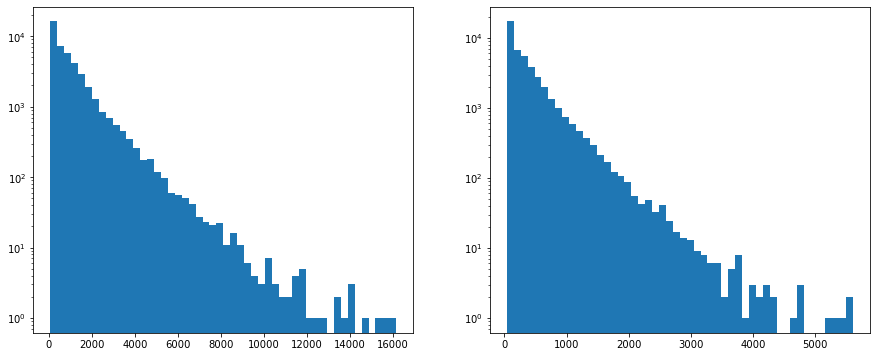

In [9]:
wordcount = df_f.speech.apply(lambda x: len(x.split())).values
lemmacount = df_f.lemmas_ngrams.apply(len).values

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

## PCA dimensionality reduction

In [46]:
np.random.seed(26)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

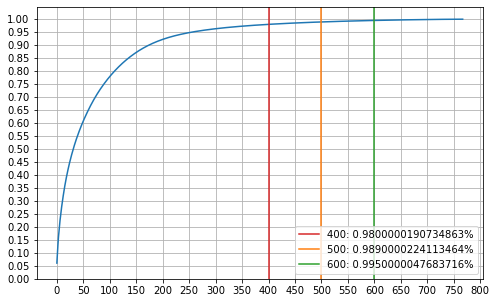

In [48]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,801,50))
ax.set_yticks(np.arange(0,1.05,0.05))

v = 400
ax.axvline(v, c='tab:red', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 500
ax.axvline(v, c='tab:orange', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 600
ax.axvline(v, c='tab:green', label=f'{v}: {np.around(cum_evr[v], 3)}%')

ax.legend()

plt.show()

In [49]:
# don't run if loading embeddings
embeddings = PCA(n_components=500, random_state=26).fit_transform(corpus_embeddings)

## umap dimensionality reduction

#### get MP party list

In [3]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)

In [4]:
MP_party = df_orig[['display_as', 'party']].copy()
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

del df_orig
gc.collect()

0

In [5]:
MP_party.head()

,party
display_as,
John Bercow,Speaker
Peter Lilley,Conservative
Donald Foster,Liberal Democrat
Harriet Harman,Labour
David Cameron,Conservative


In [6]:
names = [x[2] for x in df_f.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]

In [50]:
np.unique(parties)

array(['Alliance', 'Conservative', 'Democratic Unionist Party',
       'Green Party', 'Independent', 'Labour', 'Labour (Co-op)',
       'Liberal Democrat', 'Plaid Cymru', 'Respect',
       'Scottish National Party', 'Social Democratic & Labour Party',
       'Speaker', 'Ulster Unionist Party'], dtype='<U32')

In [51]:
party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

In [52]:
# don't run if loading reduced embeddings
reducer = umap.UMAP(n_neighbors=15, 
                    min_dist=0,
                    metric='cosine',
                    low_memory=False)
X = reducer.fit_transform(embeddings) # dimension reduced embedding

In [58]:
# don't run if loading reduced embeddings
with open('umap_embeddings.pkl', 'wb') as f:
    pickle.dump(X, f)

# run to load reduced embeddings
# with open('umap_embeddings.pkl', 'rb') as f:
#     X = pickle.load(f)

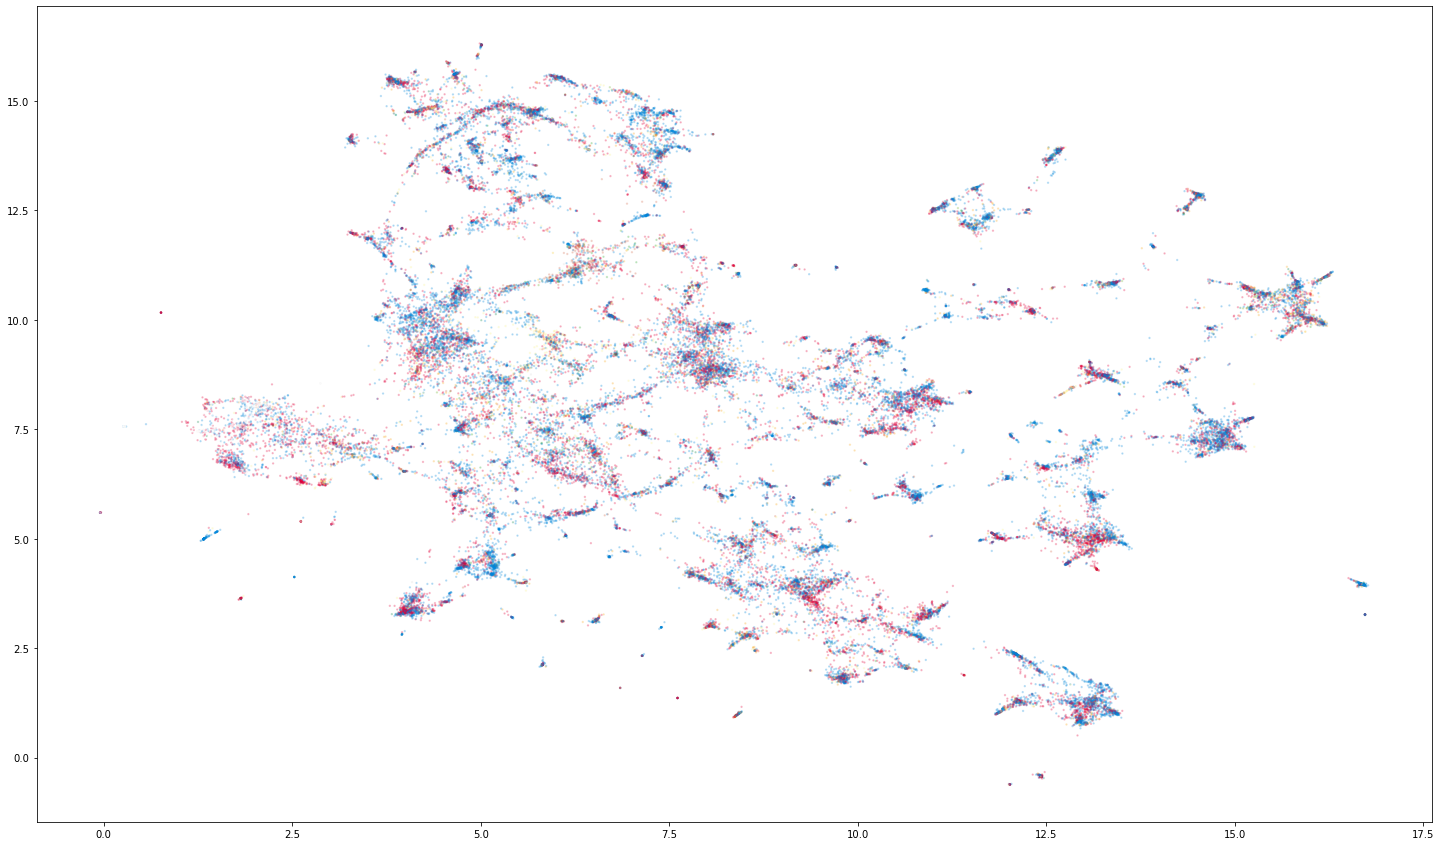

In [54]:
plt.figure(figsize=(25,15))
plt.scatter(X[:,0], X[:,1], s=2, alpha=.2, c=c)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

# clustering

these parameters tuned manually - for this dataset captures clusters of different sizes and densities well

In [56]:
import hdbscan

In [57]:
for eps in list(np.arange(0.1,0.2,0.01)):
    
    eps = float(eps)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                                min_samples=30,
                                cluster_selection_epsilon=eps,
                                cluster_selection_method='eom')

    cluster_labels = clusterer.fit_predict(X)

    label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                                 len(np.unique(cluster_labels)) - 1,
                                 replace=False)
    label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
    label_map[-1] = -1

    cluster_labels = np.array([label_map[x] for x in cluster_labels])

    cmap = plt.get_cmap('rainbow')
    cmap.set_under('black')  # Color for values less than vmin

    plt.figure(figsize=(15,10))
    plt.scatter(X[:, 0], X[:, 1], 
                s=3, alpha=.2, c=cluster_labels,
                cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
    # plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
    plt.title(f'eps: {eps}')
    plt.show()

OSError: [Errno 12] Cannot allocate memory

In [185]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30,
                            min_samples=30,
                            cluster_selection_epsilon=0.14,
                            cluster_selection_method='eom')

cluster_labels = clusterer.fit_predict(X)

In [186]:
label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                             len(np.unique(cluster_labels)) - 1,
                             replace=False)
label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
label_map[-1] = -1

cluster_labels = np.array([label_map[x] for x in cluster_labels])

<ipython-input-187-8fd11ad9381c>:2: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))



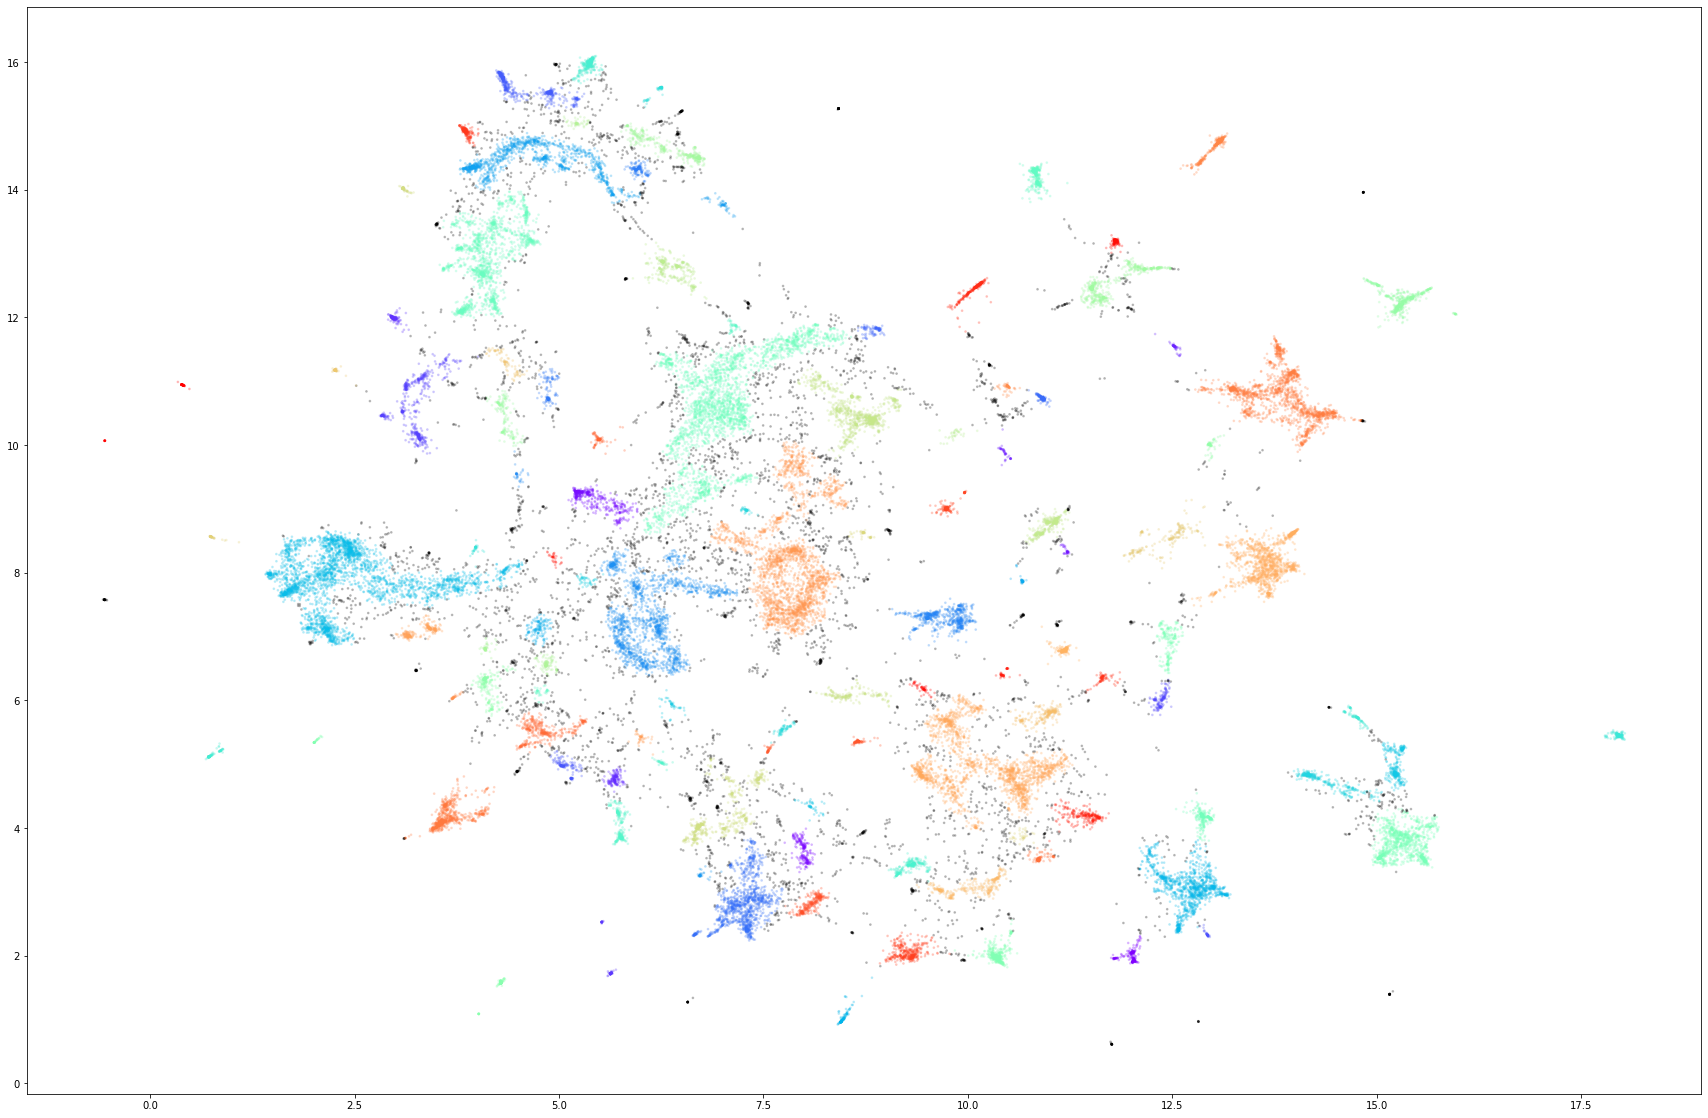

In [187]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(30,20))
plt.scatter(X[:, 0], X[:, 1], 
            s=3, alpha=.2, c=cluster_labels,
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

<ipython-input-188-51abcb098c47>:2: MatplotlibDeprecationWarning:

You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))



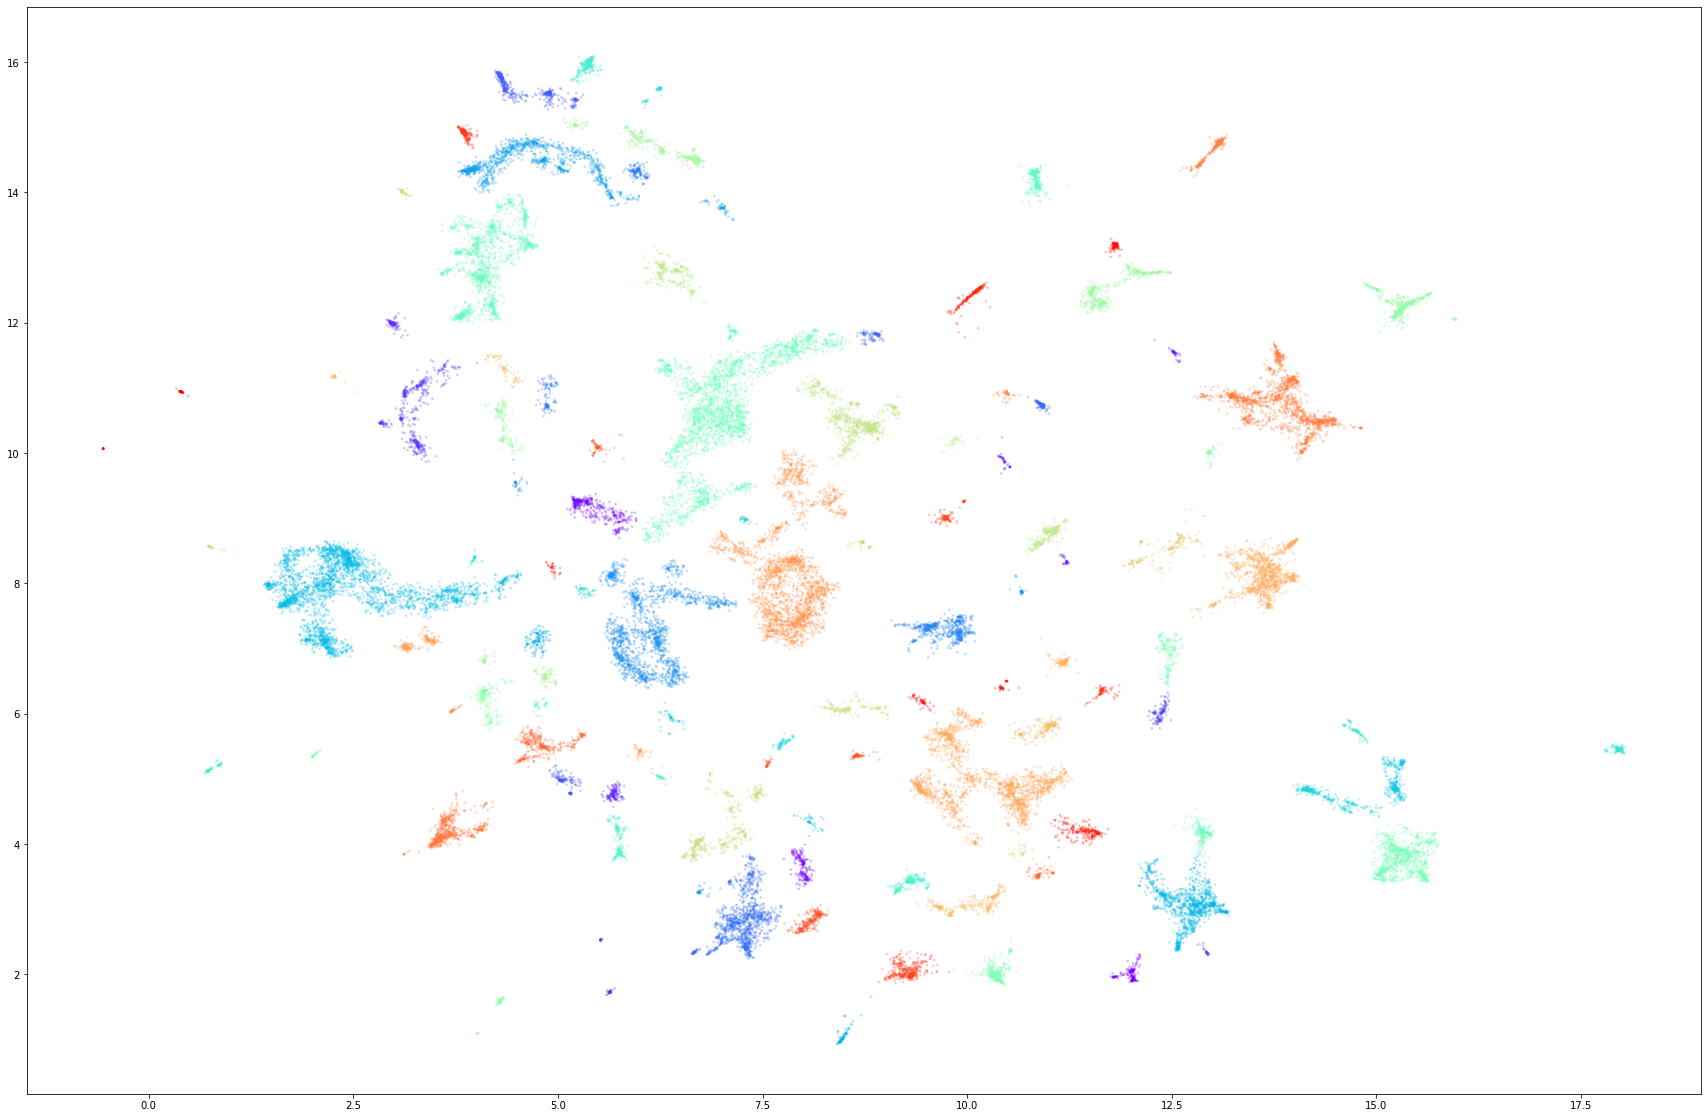

In [188]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(30,20))
plt.scatter(X[(cluster_labels != -1), 0], X[(cluster_labels != -1), 1], 
            s=3, alpha=.2, c=cluster_labels[(cluster_labels != -1)],
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
# plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan4.png', dpi=200)
plt.show()

# ploty: interactive scatter & centroids

In [189]:
df_proj = pd.DataFrame(X)
df_proj['cluster'] = cluster_labels

In [190]:
df_proj

,0,1,cluster
0,1.924181,7.348797,29
1,6.465519,9.015661,50
2,6.007670,9.077442,-1
3,7.298501,8.302910,86
4,7.232193,8.046565,-1
...,...,...,...
43766,7.398877,8.550894,86
43767,7.591819,8.161416,86
43768,7.256782,8.470014,86
43769,2.286596,8.290070,29


In [191]:
import plotly.express as px
fig = px.scatter(df_proj, x=0, y=1, 
                 opacity=0.2,
                 color='cluster', hover_data=['cluster'],
                 height=800, width=1200)
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
fig.write_html("clustered_embeddings.html")
# fig.show()

In [192]:
### centroids -- old ###

# df_clusters = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})

# X_centroids = df_clusters[[0,1]].values[1:]
# cluster_size = df_clusters['cluster'].values[1:]

# fig, ax = plt.subplots(figsize=(20,20))
# ax.scatter(X_centroids[:,0], X_centroids[:,1], s=cluster_size*3, alpha=0.2)
# for i, txt in enumerate(df_clusters.index.values[1:]):
#     ax.annotate(txt, 
#                 (X_centroids[i,0], X_centroids[i,1]),
#                 ha='center', va='center',
#                 fontsize=10,
#                 alpha=0.5
#                )
# plt.savefig('pp-mpnet-bv2-pca500-nn15-md0-cosine_centroids.png')

# cluster speeches EDA

## must reload df_f

In [193]:
df_f['cluster'] = cluster_labels

In [194]:
with open(f'filtered_dt.pkl', 'rb') as f:
    dt = pickle.load(f)

N = 90
with open(f'topic-models/coarse/lda_mallet_{N}.pkl', 'rb') as f:
    lda = pickle.load(f)

In [195]:
dt.shape

(43771, 90)

In [196]:
df_f['topic_dist'] = list(dt)

In [197]:
df_f.sample(5)

,,,speech,lemmas_ngrams,cluster,topic_dist
date,heading,display_as,,,,
2012-07-11,United Kingdom Borders Backbench Business — Sittings of the House,Robert Smith,This is probably the best laid out Order Paper...,"[probably, well, lay, order, paper, debate, fa...",84,"[0.0033167495854063, 0.0033167495854063, 0.003..."
2017-11-14,HOSPITAL CAR PARKING CHARGES (ABOLITION) Tax Avoidance and Evasion,Craig Mackinlay,"Thank you, Mr Speaker. I am glad to have caugh...","[thank, mr_speaker, glad, catch_eye, internati...",83,"[0.0012210012210012, 0.0012210012210012, 0.001..."
2018-10-09,GOVERNMENT OVERSEAS AID COMMITMENT: PRIVATE INVESTMENT EU Exit Negotiations,Jack Dromey,Jaguar is on a three-day week and Land Rover’s...,"[jaguar, day, week, land_rover, solihull, plan...",50,"[0.0036429872495446, 0.0036429872495446, 0.003..."
2012-06-11,DEFENCE New Equipment (Expenditure),Philip Hammond,"Before I answer the question, I am sure the Ho...","[answer, question, sure, wish, join, pay_tribu...",49,"[0.0042000763650248, 0.0007636502481863306, 0...."
2012-01-23,Opposition Day — [Un-allotted Day] Food Prices and Food Poverty,Sarah Wollaston,"In the brief time that I have to speak, I shal...","[brief, speak, shall, link, food, poverty, obe...",-1,"[0.0013550135501355, 0.0013550135501355, 0.001..."


In [198]:
groups = df_f.groupby('cluster')

In [199]:
df_cluster = groups.agg({'lemmas_ngrams': list})

In [200]:
df_cluster['topic_dist'] = groups['topic_dist'].apply(np.mean)

In [201]:
df_cluster['size'] = groups.count().speech

In [202]:
def flatten(list_of_lists):
    res = []
    for l in list_of_lists:
        res += l
    return res

# def flatten_lemmas(el):
#     return flatten(el.values.ravel()[0])

In [203]:
df_cluster['lemmas_ngrams'] = df_cluster.lemmas_ngrams.apply(flatten)

In [204]:
df_cluster

,lemmas_ngrams,topic_dist,size
cluster,,,
-1,"[gentleman, confirm, reading, situation, resul...","[0.010849475967013526, 0.006822885257404897, 0...",4853
0,"[try, brief, short, congratulate, north, warwi...","[0.00388585781547519, 0.003785428221091703, 0....",205
1,"[grateful, lady, question, great, interest, of...","[0.0029419189270299133, 0.005535124714090751, ...",198
2,"[think, happen, callaghan, fall, election, cal...","[0.01340353770237797, 0.004966108135056343, 0....",421
3,"[delighted, bill, impinge, ticket, touting, pr...","[0.00473665762156303, 0.004471777039873248, 0....",33
...,...,...,...
104,"[grateful, backbench_business_committee, oppor...","[0.002952253353447489, 0.0072126866857136545, ...",44
105,"[assurance, word, timetable, question, carmart...","[0.002832458437418852, 0.003968775334947935, 0...",32
106,"[public, consultation, currently, badger, cont...","[0.0025842781687468973, 0.0022923210962187504,...",130


## LDA topic distribution in clusters

In [205]:
from scipy.stats import entropy
df_cluster['entropy'] = entropy(np.vstack(df_cluster.topic_dist.values), base=2, axis=1)

In [206]:
df_cluster['I_eff'] = 2 ** df_cluster.entropy

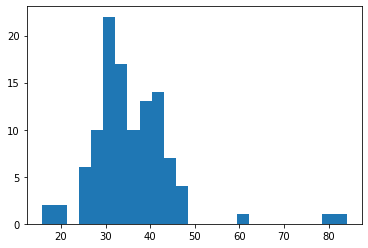

In [207]:
plt.hist(df_cluster.I_eff, bins=25)
plt.show()

(0.6159605404092502, 7.943070276481449e-13)


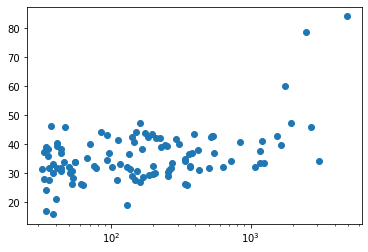

In [208]:
x = df_cluster['size']
y = df_cluster['I_eff']
plt.scatter(x, y)
plt.xscale('log')

from scipy.stats import pearsonr
print(pearsonr(x,y))

In [209]:
df_centroids = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})[[0,1]]

In [210]:
df_centroids.head(5)

,0,1
,mean,mean
cluster,,
-1,7.421206,8.179990
0,11.991148,2.000914
1,7.983693,3.645027
2,5.448175,9.134201
3,11.200582,8.345407


### tfidf

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
dummy = lambda x: x
vectorizer = TfidfVectorizer(max_df=0.8, tokenizer=dummy, lowercase=False)
cluster_tfidf = vectorizer.fit_transform(df_cluster.lemmas_ngrams.values)

In [212]:
id_to_w = {v:k for k,v in vectorizer.vocabulary_.items()}

In [213]:
cluster_tfidf_word_ids = np.argsort(cluster_tfidf.toarray(), axis=1)[:, ::-1][:, :10]

In [214]:
cluster_tfidf_word_ids[0]

array([58390, 52985, 32454, 11427, 21217, 49782, 36770, 45241, 33053,
       36137])

In [215]:
top_vocab_words = np.vectorize(id_to_w.get)(cluster_tfidf_word_ids)

In [216]:
df_cluster['tfidf_words'] = [" ".join(x) for x in top_vocab_words]

## summarise clusters

In [217]:
def plot_cluster_topic_dist(cluster_id, df_cluster=df_cluster):
    plt.figure(figsize=(20,5))
    
    dist = df_cluster.loc[cluster_id].topic_dist
    N = len(dist)
    
    mu = np.mean(dist)
    std = np.std(dist)
    
    significant_topic_ids = np.where((dist - mu)/std > 1)[0]
    
    colors = np.repeat('k', N)
    colors[significant_topic_ids] = 'r'
    
    plt.bar(np.arange(N), dist,
           color=colors)
    plt.xticks(np.arange(0,N,5))
    
    plt.title(f'cluster {cluster_id} topic distribution')
    plt.show()
    
    order = np.argsort(dist[significant_topic_ids])[::-1]
    return zip(significant_topic_ids[order], dist[significant_topic_ids][order])

def summarise_cluster(cluster_id, df_cluster=df_cluster):
    significant_topic_ids = plot_cluster_topic_dist(cluster_id, df_cluster)
    for topic_id, p in significant_topic_ids:
        print(f'{topic_id}  {np.around(p, 3)}\n{lda.print_topic(topic_id)}\n')
        
    print(f'top tfidf words: {df_cluster.loc[cluster_id, "tfidf_words"]}\n')
    
    print(f"size: {df_cluster.loc[cluster_id,'size']}")
    print(f'centroid: {df_centroids.loc[cluster_id].values}')
    print('\n')

In [218]:
most_coherent_cluster_ids = df_cluster.sort_values(by='I_eff').head(10).index
df_cluster.loc[most_coherent_cluster_ids]

,lemmas_ngrams,topic_dist,size,entropy,I_eff,tfidf_words
cluster,,,,,,
38,"[beg, order, june, identity, documents, bill, ...","[0.0018959933536641794, 0.0044486729658131515,...",38,3.979889,15.778514,schedules forthwith crown clauses pm paragraph...
55,"[beg, follow, stand, order, private, business,...","[0.002463381193986059, 0.002429142314703966, 0...",34,4.080362,16.916530,certification certify consent legislative_comp...
106,"[public, consultation, currently, badger, cont...","[0.0025842781687468973, 0.0022923210962187504,...",130,4.239280,18.886457,badger cull cattle tb vaccine bovine_tb vaccin...
75,"[gentleman, seek, leave, motion, relate, publi...","[0.0058651092298976585, 0.006233637374059332, ...",40,4.389618,20.960749,satisfied english item specify standing sedent...
87,"[representation, cross, media, ownership, tell...","[0.0077672303303821634, 0.347007814128256, 0.0...",34,4.596895,24.199326,ofcom sky plurality cma broadcasting merger fo...
48,"[congratulate, plymouth, moor, view, alison, s...","[0.005342734657895307, 0.0038148059275362745, ...",351,4.683077,25.688972,fishery fish fisherman fishing quota discard f...
37,"[week, nobel, peace, prize, award, liu, xiaobo...","[0.016807561050111733, 0.011429512738252264, 0...",63,4.684524,25.714747,hong_kong china chinese extradition declaratio...
77,"[great, passionate, speech, tonight, like, spe...","[0.01073445549190334, 0.005546655050443323, 0....",52,4.707509,26.127712,mandela nelson_mandela apartheid south_africa ...
72,"[constituent, nottingham_east, pakistani, kash...","[0.005248891057567305, 0.0071239864714664, 0.0...",61,4.710940,26.189928,kashmir pakistan kashmiri india indian jammu k...


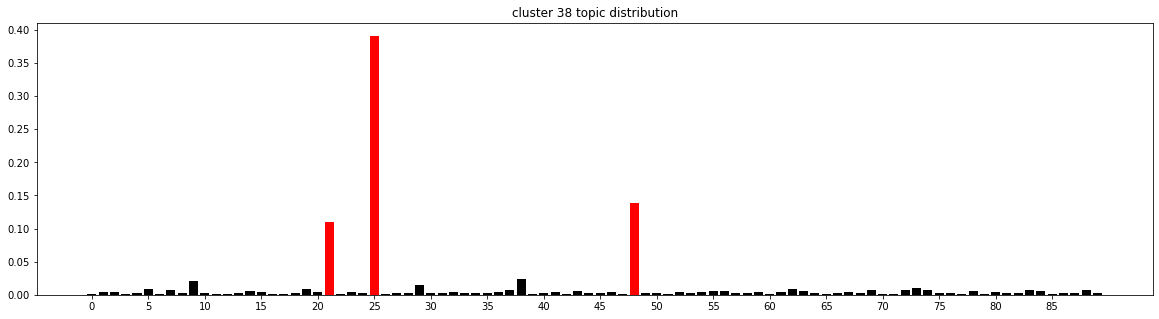

25  0.391
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

48  0.139
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

21  0.11
0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

top tfidf words: schedules forthwith crown clauses pm paragraph exempted sitting commencement standing

size: 38
centroid: [3.9797328 8.369295 ]




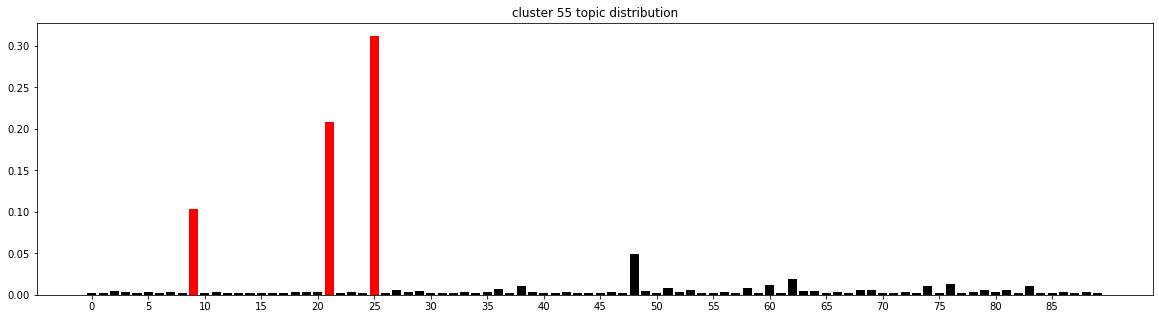

25  0.312
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

21  0.209
0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

9  0.103
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

top tfidf words: certification certify consent legislative_competence legislative paragraph exclusively grand resume standing

size: 34
centroid: [2.026709  5.3642507]




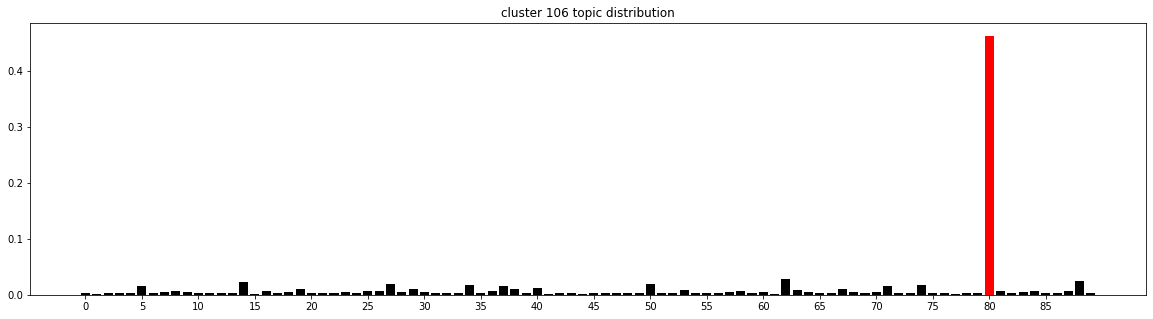

80  0.463
0.027*"dog" + 0.023*"animal" + 0.012*"disease" + 0.010*"ban" + 0.010*"control" + 0.009*"badger" + 0.008*"cattle" + 0.008*"animal_welfare" + 0.008*"cull" + 0.007*"tb"

top tfidf words: badger cull cattle tb vaccine bovine_tb vaccination disease badger_cull farmer

size: 130
centroid: [11.80394  13.180967]




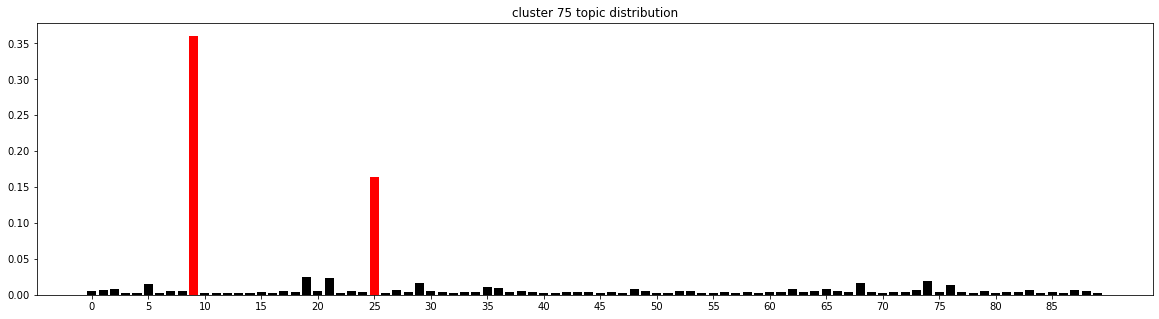

9  0.36
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

25  0.164
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

top tfidf words: satisfied english item specify standing sedentary_position tuesday standing_orders chuntere barnett_consequential

size: 40
centroid: [0.76848626 8.554171  ]




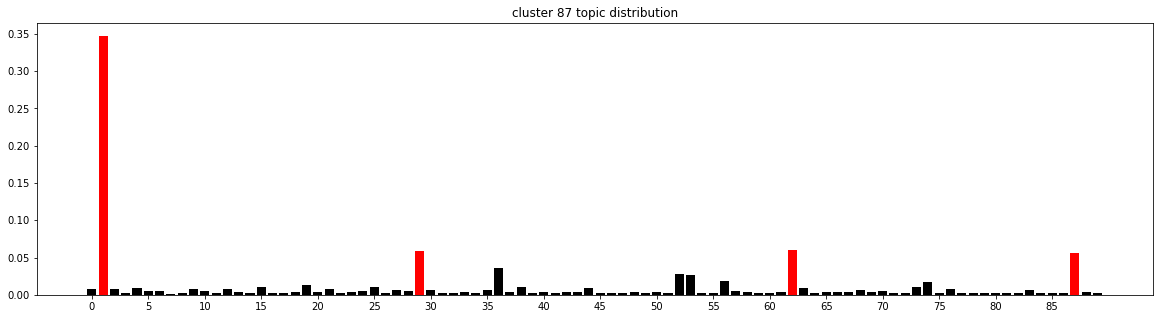

1  0.347
0.047*"bbc" + 0.028*"press" + 0.022*"news" + 0.022*"medium" + 0.017*"public" + 0.015*"newspaper" + 0.013*"radio" + 0.010*"journalist" + 0.009*"charter" + 0.008*"television"

62  0.06
0.046*"review" + 0.027*"consultation" + 0.025*"information" + 0.025*"publish" + 0.018*"decision" + 0.017*"report" + 0.016*"assessment" + 0.015*"response" + 0.014*"impact" + 0.014*"department"

29  0.059
0.026*"process" + 0.023*"clear" + 0.018*"agreement" + 0.015*"decision" + 0.014*"set" + 0.014*"gentleman" + 0.012*"deal" + 0.011*"place" + 0.010*"hope" + 0.010*"discussion"

87  0.056
0.045*"inquiry" + 0.029*"report" + 0.023*"investigation" + 0.021*"evidence" + 0.013*"happen" + 0.011*"question" + 0.010*"independent" + 0.009*"case" + 0.009*"public" + 0.009*"allegation"

top tfidf words: ofcom sky plurality cma broadcasting merger fox murdoch undertaking quasi

size: 34
centroid: [3.7226605 6.0531197]




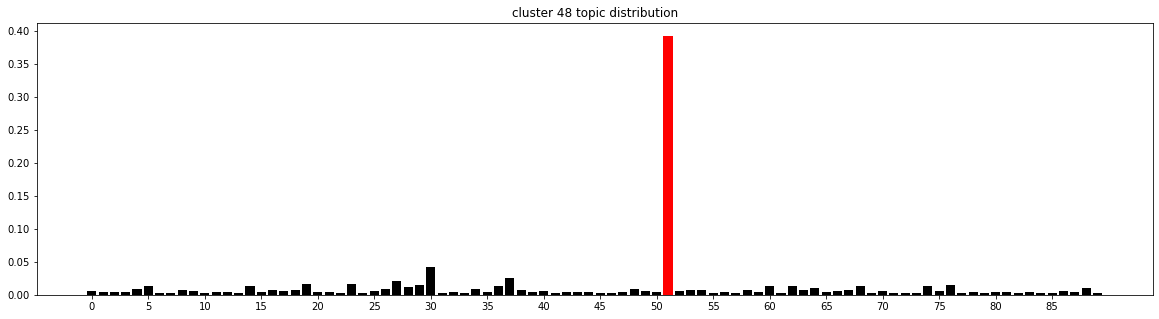

51  0.392
0.019*"port" + 0.016*"fishing" + 0.016*"fish" + 0.015*"sea" + 0.011*"fishery" + 0.011*"fisherman" + 0.010*"uk" + 0.009*"water" + 0.009*"catch" + 0.009*"marine"

top tfidf words: fishery fish fisherman fishing quota discard fishing_industry vessel common_fishery_policy cfp

size: 351
centroid: [10.833464 14.205231]




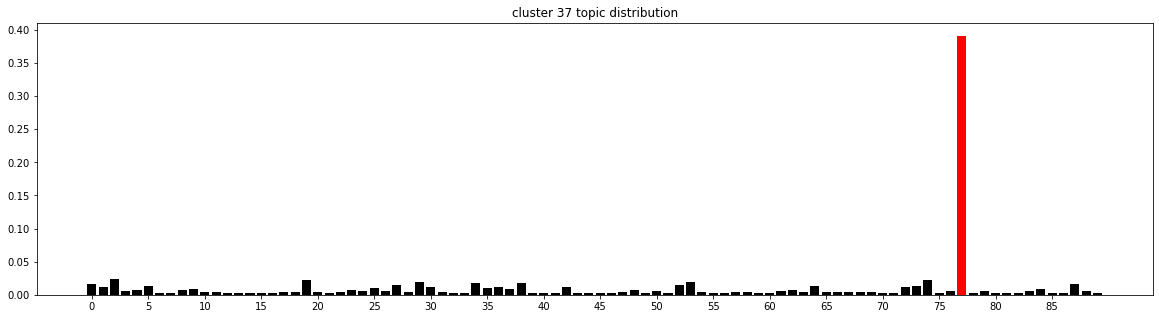

77  0.391
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

top tfidf words: hong_kong china chinese extradition declaration sino lam protest taiwan beijing

size: 63
centroid: [ 6.196022 15.537674]




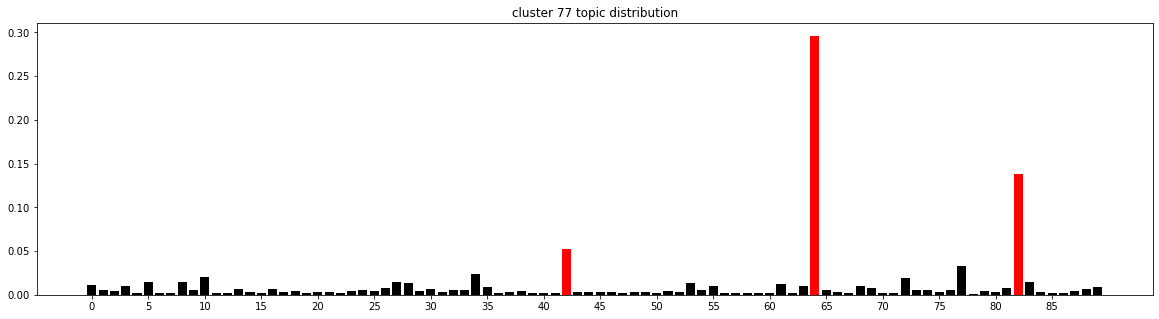

64  0.296
0.021*"great" + 0.013*"life" + 0.012*"today" + 0.011*"world" + 0.010*"day" + 0.010*"speak" + 0.009*"stand" + 0.008*"nation" + 0.008*"proud" + 0.008*"politic"

82  0.138
0.041*"petition" + 0.020*"recall" + 0.020*"urge" + 0.019*"constituent" + 0.017*"sign" + 0.017*"state" + 0.017*"commons" + 0.016*"mr" + 0.013*"john" + 0.011*"constituency"

42  0.052
0.037*"war" + 0.016*"world" + 0.016*"day" + 0.011*"man" + 0.010*"remember" + 0.008*"event" + 0.008*"kill" + 0.008*"british" + 0.008*"history" + 0.007*"today"

top tfidf words: mandela nelson_mandela apartheid south_africa anc african reconciliation forgiveness africans black

size: 52
centroid: [ 2.2721288 11.167429 ]




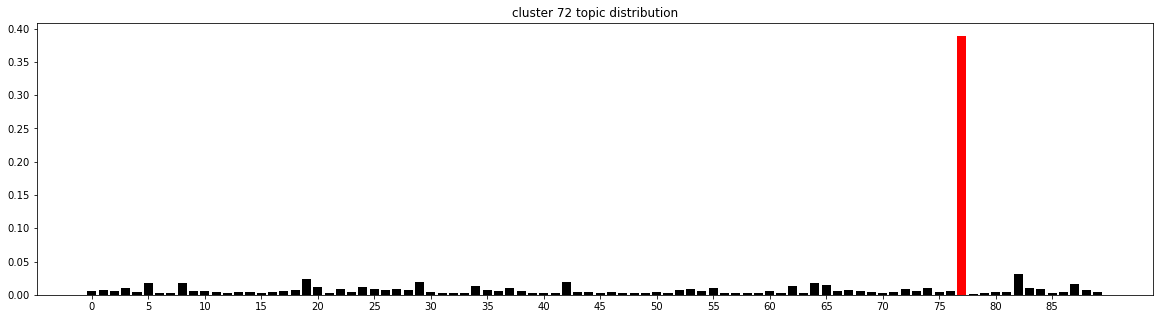

77  0.389
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

top tfidf words: kashmir pakistan kashmiri india indian jammu kashmiris pellet pakistani un

size: 61
centroid: [ 3.1089375 14.006613 ]




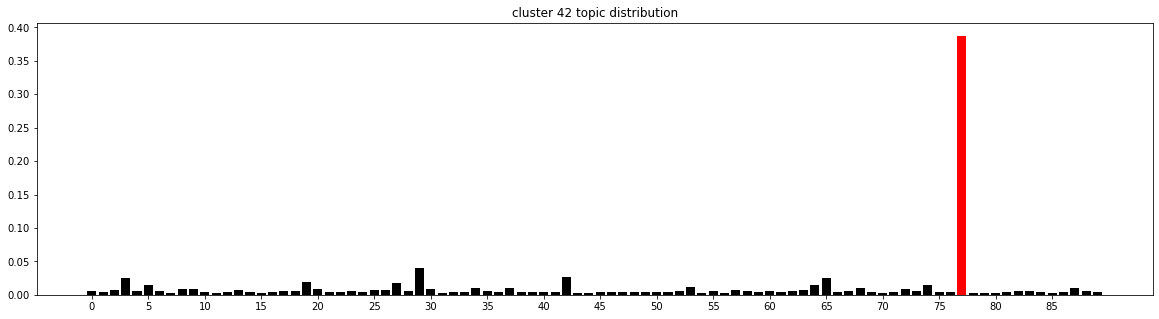

77  0.387
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

top tfidf words: israel palestinian israeli gaza palestinians peace hamas palestine israelis jerusalem

size: 339
centroid: [ 5.363662 15.957739]




In [219]:
for cluster_id in most_coherent_cluster_ids:
    summarise_cluster(cluster_id)

In [221]:
least_coherent_cluster_ids = df_cluster.sort_values(by='I_eff').tail(10).index
df_cluster.loc[least_coherent_cluster_ids]

,lemmas_ngrams,topic_dist,size,entropy,I_eff,tfidf_words
cluster,,,,,,
78,"[home_secretary, ally, debate, afternoon, havi...","[0.011563307218848648, 0.0051022282118448, 0.0...",85,5.466218,44.207457,terrorist terrorism intelligence counter_terro...
10,"[conservative, party, elect, promise, slash, p...","[0.003495023833077706, 0.0031556183232502115, ...",150,5.468222,44.268920,rural rural_area liverpool social_care urban c...
50,"[gentleman, explain, set, artificially, high, ...","[0.008095838498045769, 0.004789307000001092, 0...",2696,5.513650,45.685056,referendum withdrawal_agreement treaty backsto...
33,"[hour, debate, argue, unfortunately, part, bil...","[0.010897784699205307, 0.010245011754672252, 0...",47,5.521217,45.925308,consent adoption certify regulator offender ap...
47,"[impact, assessment, prepare, bribery, bill, i...","[0.02158989330855442, 0.0041563351135908925, 0...",37,5.533314,46.311979,dna cyber database cyber_security convict arre...
6,"[congratulate, hornsey, wood, green, lynne, fe...","[0.005690749862746819, 0.00909316729290807, 0....",160,5.561778,47.234808,menopause gender women female pension equality...
83,"[mr_speaker, extremely, grateful, shadow_chanc...","[0.002993559547544866, 0.004214587838528533, 0...",1952,5.565000,47.340386,debt banking obr deficit forecast tax_avoidanc...
21,"[strange, debate, amendment, name, st_ives, an...","[0.006709111697866595, 0.006569159889623076, 0...",1749,5.904315,59.892984,subsection insert amendment_page_line_leave pe...
86,"[begin, grateful, speaker, opportunity, raise,...","[0.005705503787047763, 0.008266847417229061, 0...",2496,6.298992,78.738209,referendum devolution snp assembly mental_heal...


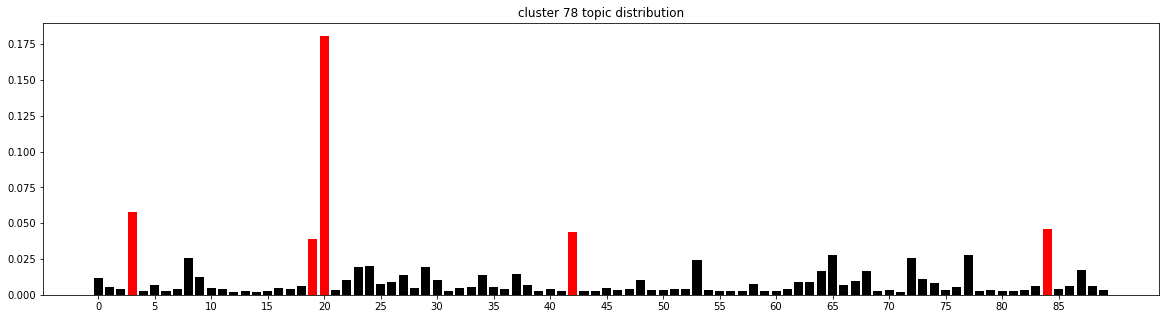

20  0.181
0.042*"security" + 0.015*"power" + 0.015*"terrorism" + 0.014*"threat" + 0.014*"intelligence" + 0.014*"national" + 0.013*"agency" + 0.012*"home_secretary" + 0.012*"terrorist" + 0.010*"order"

3  0.057
0.015*"russia" + 0.014*"action" + 0.013*"syria" + 0.013*"iraq" + 0.012*"security" + 0.012*"military" + 0.009*"force" + 0.009*"russian" + 0.009*"nato" + 0.008*"world"

84  0.046
0.117*"police" + 0.033*"crime" + 0.029*"force" + 0.020*"officer" + 0.019*"police_officer" + 0.017*"policing" + 0.015*"service" + 0.013*"community" + 0.012*"public" + 0.010*"home_secretary"

42  0.044
0.037*"war" + 0.016*"world" + 0.016*"day" + 0.011*"man" + 0.010*"remember" + 0.008*"event" + 0.008*"kill" + 0.008*"british" + 0.008*"history" + 0.007*"today"

19  0.039
0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*"ensure" + 0.028*"raise" + 0.025*"absolutely" + 0.019*"question" + 0.016*"make" + 0.016*"continue" + 0.015*"happy"

top tfidf words: terrorist terrorism intelligence counter_terrorism

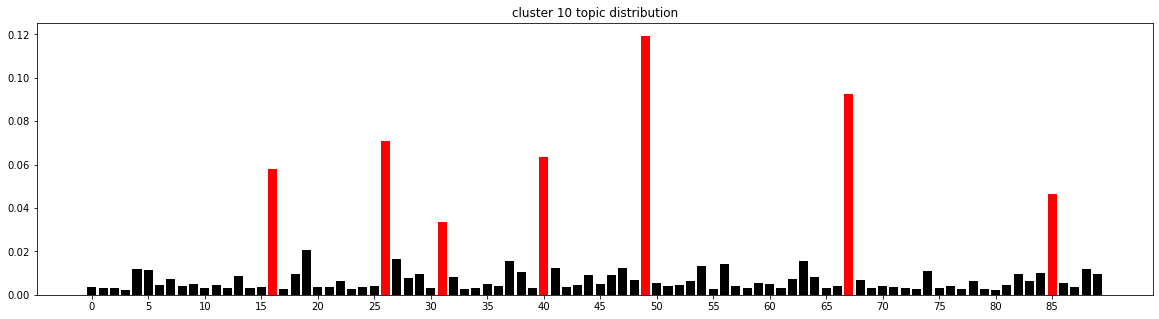

49  0.119
0.093*"local" + 0.074*"council" + 0.053*"local_authority" + 0.029*"planning" + 0.025*"community" + 0.024*"authority" + 0.023*"development" + 0.021*"area" + 0.020*"plan" + 0.012*"site"

67  0.092
0.061*"money" + 0.055*"funding" + 0.054*"million" + 0.038*"fund" + 0.037*"billion" + 0.034*"spend" + 0.033*"budget" + 0.021*"cost" + 0.019*"spending" + 0.019*"increase"

26  0.071
0.065*"cut" + 0.014*"face" + 0.012*"lose" + 0.012*"poor" + 0.012*"fail" + 0.011*"bad" + 0.011*"budget" + 0.011*"impact" + 0.010*"real" + 0.009*"million"

40  0.063
0.031*"area" + 0.030*"rural" + 0.028*"constituency" + 0.019*"community" + 0.017*"broadband" + 0.015*"rural_area" + 0.015*"service" + 0.011*"cornwall" + 0.011*"constituent" + 0.010*"access"

16  0.058
0.054*"city" + 0.034*"area" + 0.032*"london" + 0.027*"local" + 0.025*"region" + 0.020*"north" + 0.017*"north_east" + 0.017*"regional" + 0.013*"deal" + 0.010*"economic"

85  0.047
0.071*"tax" + 0.051*"rate" + 0.028*"increase" + 0.023*"pay" + 0.017*"mea

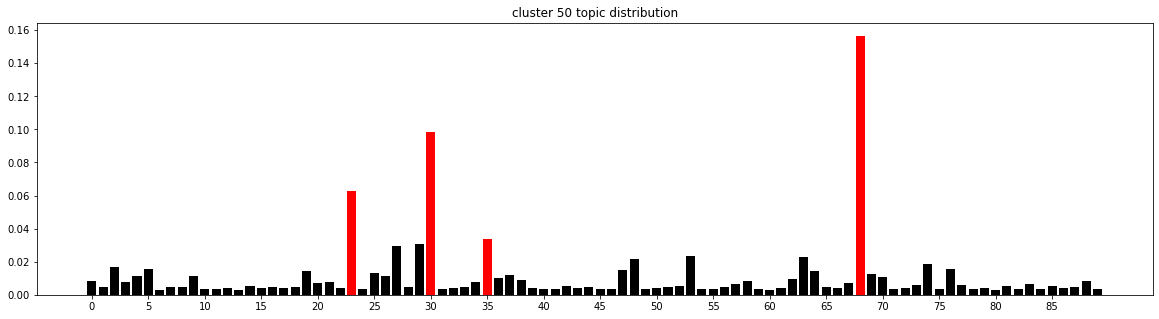

68  0.156
0.059*"vote" + 0.055*"deal" + 0.030*"brexit" + 0.028*"leave" + 0.025*"referendum" + 0.022*"prime_minister" + 0.011*"european_union" + 0.011*"parliament" + 0.010*"eu" + 0.008*"remain"

30  0.099
0.075*"eu" + 0.044*"uk" + 0.036*"trade" + 0.023*"european_union" + 0.023*"deal" + 0.022*"leave" + 0.019*"agreement" + 0.014*"negotiation" + 0.012*"future" + 0.012*"brexit"

23  0.063
0.056*"european" + 0.038*"eu" + 0.035*"europe" + 0.028*"european_union" + 0.019*"state" + 0.017*"treaty" + 0.016*"british" + 0.013*"uk" + 0.011*"britain" + 0.011*"referendum"

35  0.034
0.073*"parliament" + 0.017*"lords" + 0.016*"power" + 0.014*"vote" + 0.014*"elect" + 0.014*"place" + 0.013*"reform" + 0.013*"party" + 0.012*"constitutional" + 0.012*"change"

top tfidf words: referendum withdrawal_agreement treaty backstop custom_union eurozone single_market opt euro democracy

size: 2696
centroid: [ 7.0240836 10.600761 ]




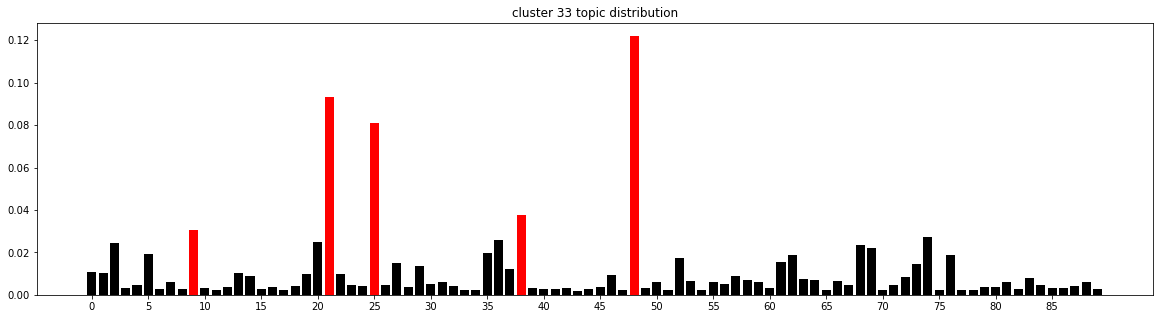

48  0.122
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

21  0.093
0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

25  0.081
0.069*"debate" + 0.046*"motion" + 0.030*"day" + 0.023*"business" + 0.022*"leader" + 0.017*"question" + 0.015*"week" + 0.012*"opportunity" + 0.012*"matter" + 0.012*"bill"

38  0.038
0.104*"committee" + 0.064*"report" + 0.027*"commission" + 0.023*"recommendation" + 0.018*"select_committee" + 0.016*"chair" + 0.012*"public" + 0.011*"parliament" + 0.011*"evidence" + 0.010*"role"

9  0.03
0.073*"order" + 0.056*"gentleman" + 0.034*"matter" + 0.027*"question" + 0.016*"hear" + 0.015*"grateful" + 0.015*"lady" + 0.013*"answer" + 0.012*"minute" + 0.010*"chair"

top tfidf words: consent adoption certify regulator offender a

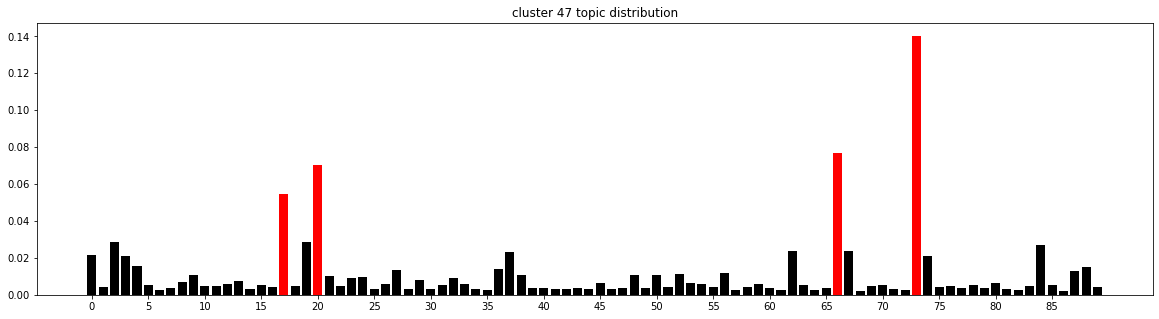

73  0.14
0.039*"case" + 0.034*"offence" + 0.025*"criminal" + 0.023*"law" + 0.021*"crime" + 0.020*"court" + 0.013*"sentence" + 0.012*"act" + 0.012*"prosecution" + 0.012*"commit"

66  0.077
0.039*"datum" + 0.025*"information" + 0.025*"online" + 0.018*"access" + 0.017*"internet" + 0.014*"technology" + 0.013*"digital" + 0.011*"space" + 0.011*"company" + 0.009*"communication"

20  0.07
0.042*"security" + 0.015*"power" + 0.015*"terrorism" + 0.014*"threat" + 0.014*"intelligence" + 0.014*"national" + 0.013*"agency" + 0.012*"home_secretary" + 0.012*"terrorist" + 0.010*"order"

17  0.054
0.040*"defence" + 0.026*"armed_force" + 0.017*"force" + 0.017*"service" + 0.015*"afghanistan" + 0.013*"military" + 0.013*"army" + 0.013*"personnel" + 0.012*"serve" + 0.010*"veteran"

top tfidf words: dna cyber database cyber_security convict arrest cyber_attack offence immigration detection

size: 37
centroid: [4.7799406 6.1265063]




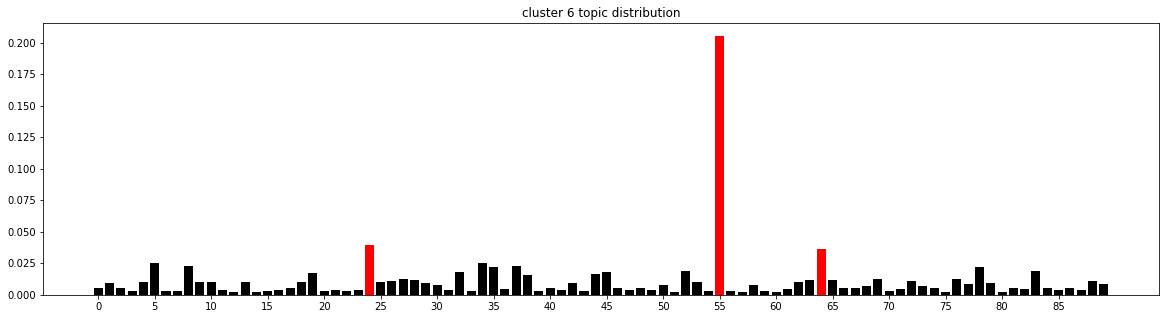

55  0.205
0.128*"woman" + 0.019*"man" + 0.018*"equality" + 0.017*"marriage" + 0.014*"change" + 0.013*"gender" + 0.010*"act" + 0.010*"female" + 0.009*"discrimination" + 0.008*"equal"

24  0.039
0.050*"victim" + 0.033*"abuse" + 0.021*"child" + 0.013*"violence" + 0.011*"report" + 0.011*"crime" + 0.010*"protect" + 0.009*"domestic_violence" + 0.009*"tackle" + 0.009*"young"

64  0.037
0.021*"great" + 0.013*"life" + 0.012*"today" + 0.011*"world" + 0.010*"day" + 0.010*"speak" + 0.009*"stand" + 0.008*"nation" + 0.008*"proud" + 0.008*"politic"

top tfidf words: menopause gender women female pension equality male girl gender_equality violence

size: 160
centroid: [5.6823125 4.7698364]




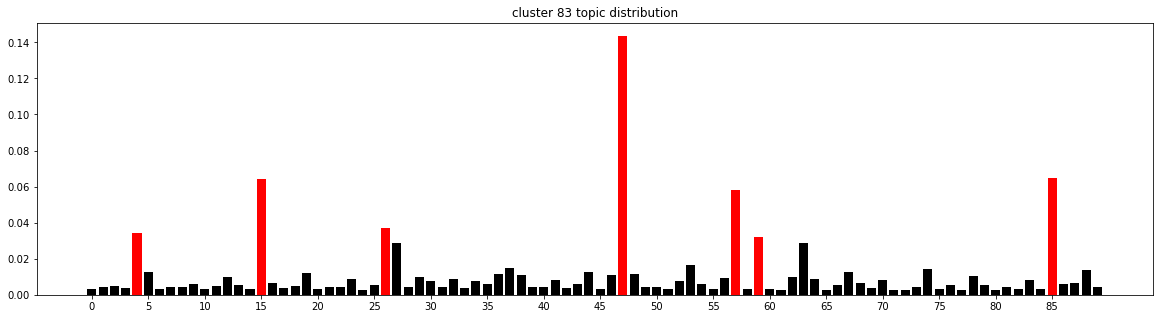

47  0.144
0.032*"economy" + 0.028*"budget" + 0.026*"economic" + 0.026*"chancellor" + 0.024*"growth" + 0.016*"deficit" + 0.016*"billion" + 0.016*"plan" + 0.013*"debt" + 0.013*"public"

85  0.065
0.071*"tax" + 0.051*"rate" + 0.028*"increase" + 0.023*"pay" + 0.017*"measure" + 0.017*"budget" + 0.015*"vat" + 0.014*"benefit" + 0.014*"high" + 0.014*"change"

15  0.064
0.053*"tax" + 0.030*"company" + 0.023*"hmrc" + 0.019*"pay" + 0.016*"uk" + 0.011*"tax_avoidance" + 0.010*"rule" + 0.009*"profit" + 0.009*"billion" + 0.008*"money"

57  0.058
0.106*"bank" + 0.042*"financial" + 0.029*"banking" + 0.013*"treasury" + 0.011*"business" + 0.011*"system" + 0.010*"sector" + 0.010*"bonus" + 0.009*"england" + 0.008*"crisis"

26  0.037
0.065*"cut" + 0.014*"face" + 0.012*"lose" + 0.012*"poor" + 0.012*"fail" + 0.011*"bad" + 0.011*"budget" + 0.011*"impact" + 0.010*"real" + 0.009*"million"

4  0.034
0.109*"business" + 0.032*"investment" + 0.031*"economy" + 0.024*"small" + 0.022*"growth" + 0.016*"sector" + 0.016*"

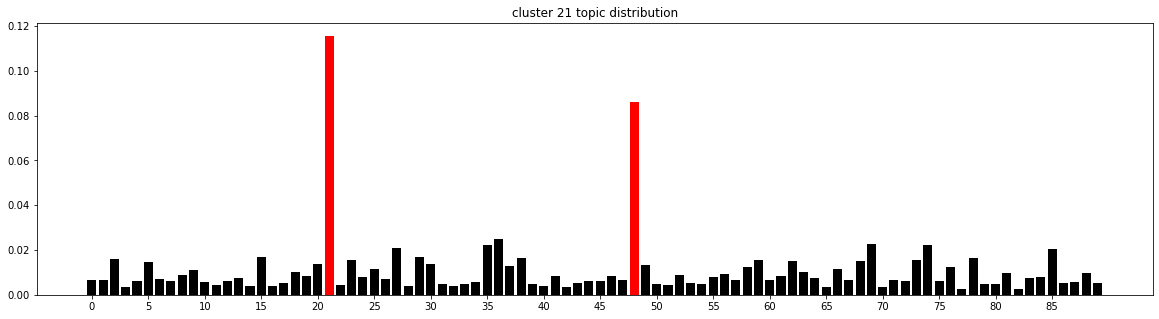

21  0.116
0.046*"act" + 0.042*"clause" + 0.037*"section" + 0.034*"amendment" + 0.024*"provision" + 0.019*"order" + 0.017*"person" + 0.015*"subsection" + 0.013*"leave" + 0.012*"require"

48  0.086
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

top tfidf words: subsection insert amendment_page_line_leave pension referendum amendment_page_line_end_insert offence amendment_page_line assembly paragraph

size: 1749
centroid: [6.113409 7.298917]




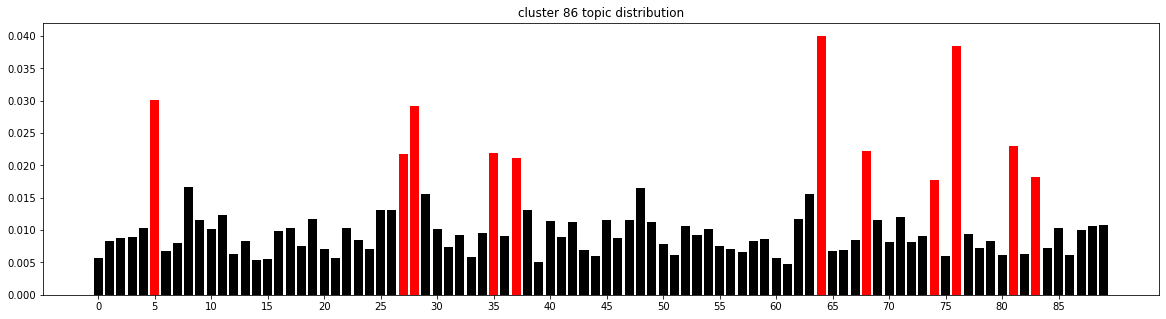

64  0.04
0.021*"great" + 0.013*"life" + 0.012*"today" + 0.011*"world" + 0.010*"day" + 0.010*"speak" + 0.009*"stand" + 0.008*"nation" + 0.008*"proud" + 0.008*"politic"

76  0.038
0.126*"scotland" + 0.102*"scottish" + 0.034*"uk" + 0.028*"parliament" + 0.023*"united_kingdom" + 0.021*"snp" + 0.019*"power" + 0.014*"party" + 0.013*"english" + 0.012*"england"

5  0.03
0.074*"debate" + 0.035*"important" + 0.031*"hear" + 0.024*"speak" + 0.022*"hope" + 0.018*"today" + 0.016*"talk" + 0.016*"speech" + 0.013*"mention" + 0.012*"thing"

28  0.029
0.036*"constituency" + 0.017*"great" + 0.012*"visit" + 0.011*"place" + 0.011*"town" + 0.009*"city" + 0.008*"represent" + 0.008*"heritage" + 0.007*"proud" + 0.007*"hope"

81  0.023
0.123*"wales" + 0.060*"welsh" + 0.020*"power" + 0.020*"assembly" + 0.013*"devolve" + 0.012*"cardiff" + 0.012*"uk" + 0.011*"devolution" + 0.010*"england" + 0.009*"welsh_assembly"

68  0.022
0.059*"vote" + 0.055*"deal" + 0.030*"brexit" + 0.028*"leave" + 0.025*"referendum" + 0.022*"pr

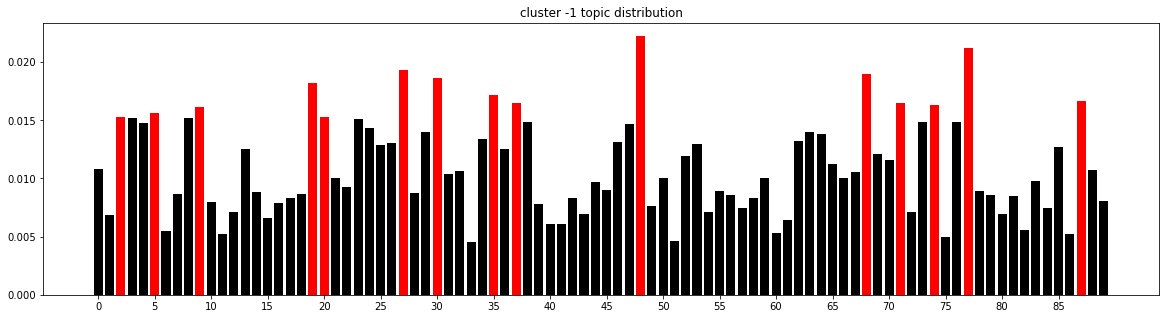

48  0.022
0.185*"bill" + 0.071*"amendment" + 0.041*"clause" + 0.022*"committee" + 0.018*"legislation" + 0.013*"provision" + 0.012*"table" + 0.011*"place" + 0.008*"hope" + 0.008*"power"

77  0.021
0.015*"human" + 0.014*"iran" + 0.013*"state" + 0.012*"israel" + 0.011*"international" + 0.010*"foreign_secretary" + 0.010*"peace" + 0.008*"president" + 0.008*"continue" + 0.007*"visit"

27  0.019
0.035*"thing" + 0.022*"problem" + 0.019*"happen" + 0.014*"talk" + 0.013*"lot" + 0.011*"find" + 0.010*"money" + 0.009*"deal" + 0.009*"idea" + 0.009*"sort"

68  0.019
0.059*"vote" + 0.055*"deal" + 0.030*"brexit" + 0.028*"leave" + 0.025*"referendum" + 0.022*"prime_minister" + 0.011*"european_union" + 0.011*"parliament" + 0.010*"eu" + 0.008*"remain"

30  0.019
0.075*"eu" + 0.044*"uk" + 0.036*"trade" + 0.023*"european_union" + 0.023*"deal" + 0.022*"leave" + 0.019*"agreement" + 0.014*"negotiation" + 0.012*"future" + 0.012*"brexit"

19  0.018
0.072*"gentleman" + 0.051*"lady" + 0.038*"important" + 0.033*"ensu

In [222]:
for cluster_id in least_coherent_cluster_ids:
    summarise_cluster(cluster_id)

In [168]:
df_cluster.sample(5)

,lemmas_ngrams,topic_dist,size,entropy,I_eff,tfidf_words
cluster,,,,,,
95,"[question, world_cup, wish, fabio, capello, en...","[0.004490550118949197, 0.009349597962200664, 0...",415,5.199355,36.741928,sport football ticket club game fa rugby fan l...
6,"[acknowledge, dangerous, certainly, misleading...","[0.003875544497758349, 0.0037149236129084555, ...",1082,5.011546,32.257134,academy pupil teacher teaching curriculum gcse...
11,"[information, department, hold, effect, indust...","[0.0044843754562806535, 0.0038652623092560916,...",275,5.069700,33.583959,airport heathrow apd aviation runway flight pa...
92,"[welcome, new, post, business, question, leade...","[0.007793854937065592, 0.0041018909793681165, ...",544,5.411609,42.565391,animal dog food farmer animal_welfare puppy ci...
1,"[constituent, nottingham_east, pakistani, kash...","[0.005248891057567305, 0.0071239864714664, 0.0...",61,4.710940,26.189928,kashmir pakistan india kashmiri indian jammu k...


## cluster timeseries

In [ ]:
def plot_cluster_freq(df, i_list, use_top_word=False):
    for i in i_list:
        label = i
        df[df.cluster == i].reset_index().set_index('date').resample('M').agg('count').rename(columns={'heading':label})[label].plot()

In [ ]:
plot_cluster_freq(df_f, [58, 59])